In [1]:
# Cell 1: Imports and Styling

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# set up nice plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Cell 2: Define Paths & Load Metadata CSVs

BASE_DIR    = "/kaggle/input/chest-xrays-indiana-university"
PROJ_CSV    = os.path.join(BASE_DIR, "indiana_projections.csv")
REPORT_CSV  = os.path.join(BASE_DIR, "indiana_reports.csv")
IMAGE_DIR   = os.path.join(BASE_DIR, "images", "images_normalized")

# Load into DataFrames
projections = pd.read_csv(PROJ_CSV)
reports     = pd.read_csv(REPORT_CSV)

# Quick sanity check
print("Projections columns:", projections.columns.tolist())
print("Reports     columns:", reports.columns.tolist())

Projections columns: ['uid', 'filename', 'projection']
Reports     columns: ['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison', 'findings', 'impression']


In [3]:
# Cell 3: Merge Metadata & Build Filepaths

# Join on the shared 'uid' column
meta = projections.merge(reports, on="uid", how="left")

# Construct full image paths
meta['filepath'] = meta['filename'].apply(lambda fn: os.path.join(IMAGE_DIR, fn))

# Filter out any entries whose image file is missing
meta = meta[meta['filepath'].map(os.path.exists)].reset_index(drop=True)
meta.to_csv('meta.csv', index=False)

print(f"Total images available: {len(meta)}")
meta.head()

Total images available: 7466


,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression,filepath
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,/kaggle/input/chest-xrays-indiana-university/i...
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,/kaggle/input/chest-xrays-indiana-university/i...
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,/kaggle/input/chest-xrays-indiana-university/i...
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,/kaggle/input/chest-xrays-indiana-university/i...
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",/kaggle/input/chest-xrays-indiana-university/i...


Total cleaned unique classes: 118
{'adipose tissue', 'spine', 'atherosclerosis', 'blood vessels', 'pulmonary artery', 'breast implants', 'pulmonary atelectasis', 'medical device', 'emphysema', 'arthritis', 'deformity', 'pulmonary fibrosis', 'heart failure', 'blister', 'airspace disease', 'technical quality of image unsatisfactory', 'sulcus', 'cavitation', 'opacity', 'costophrenic angle', 'pleural effusion', 'cardiomegaly', 'pulmonary emphysema', 'pneumoperitoneum', 'granulomatous disease', 'sclerosis', 'bone diseases, metabolic', 'pneumonectomy', 'diaphragmatic eventration', 'pectus carinatum', 'cicatrix', 'contrast media', 'aorta, thoracic', 'bone and bones', 'heart', 'pneumonia', 'cholelithiasis', 'pericardial effusion', 'lung', 'mastectomy', 'osteophyte', 'nodule', 'funnel chest', 'infiltrate', 'ribs', 'spondylosis', 'hernia, hiatal', 'trachea', 'lung, hyperlucent', 'pulmonary disease, chronic obstructive', 'abdomen', 'fibrosis', 'pneumothorax', 'epicardial fat', 'shoulder', 'trache

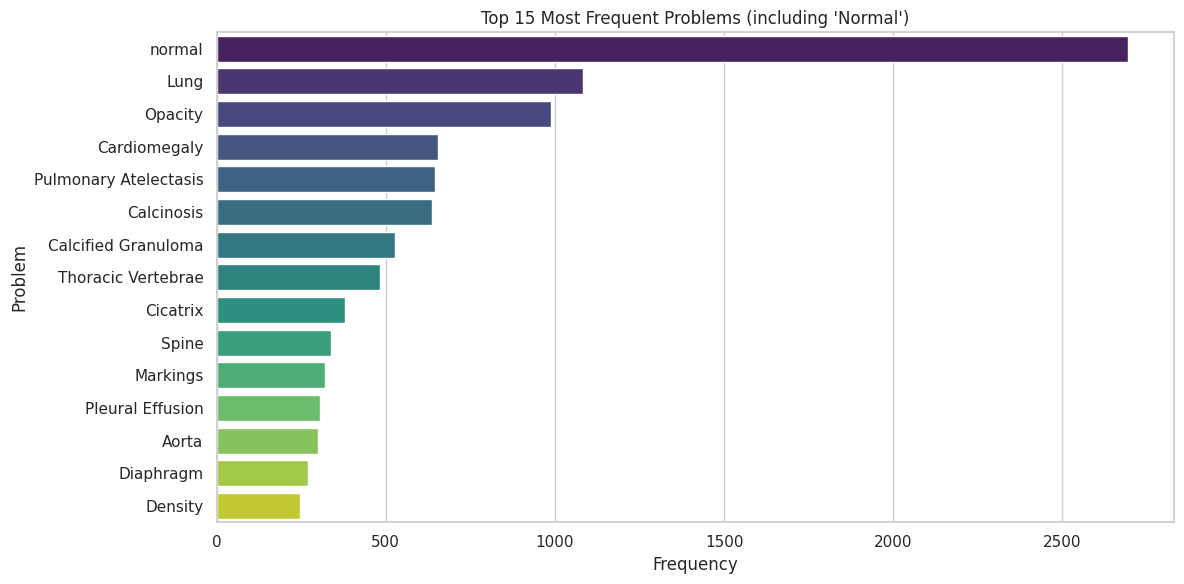

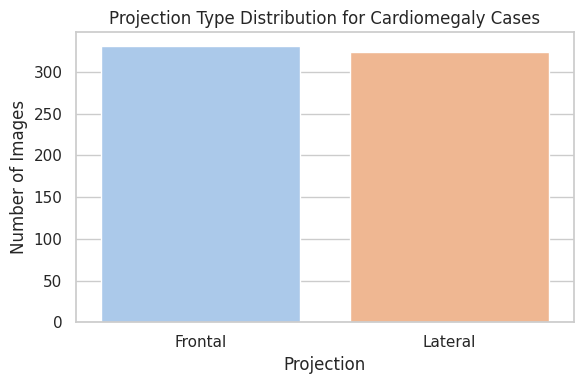

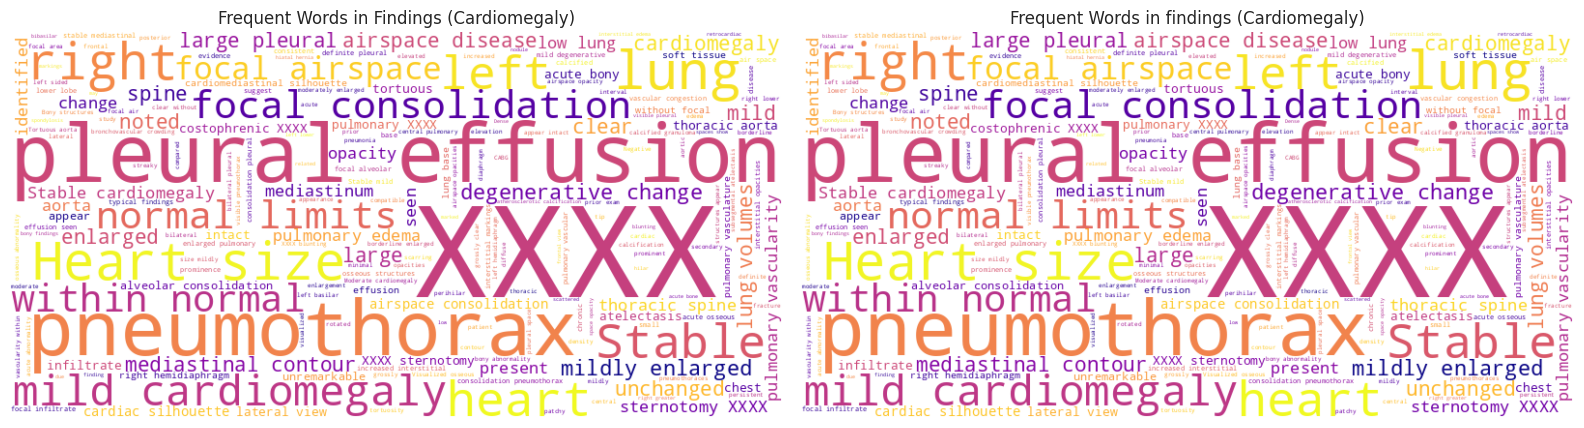

In [4]:
from collections import Counter
from wordcloud import WordCloud

# ========== Analyze the distribution of diseases ==========
# Split the "Problems" column by ';' and flatten the list
problems_split = meta['Problems'].dropna().str.split(';')
problems_flat = [item.strip() for sublist in problems_split for item in sublist]
normalized_classes = set(p.strip().lower().replace("  ", " ") for p in problems_flat)
print(f"Total cleaned unique classes: {len(normalized_classes)}")
print(normalized_classes)

# Count frequency of each problem (including 'Normal')
problem_counts = Counter(problems_flat)
top_problems = problem_counts.most_common(15)

# Create a DataFrame for plotting
problem_df = pd.DataFrame(top_problems, columns=['Problem', 'Count'])

# Plot top 15 most frequent problems
plt.figure(figsize=(12, 6))
sns.barplot(data=problem_df, x='Count', y='Problem', palette="viridis")
plt.title("Top 15 Most Frequent Problems (including 'Normal')")
plt.xlabel("Frequency")
plt.ylabel("Problem")
plt.tight_layout()
plt.show()

# ========== Analyze projection type for Cardiomegaly ==========
# Filter rows containing 'Cardiomegaly'
cardio_df = meta[meta['Problems'].str.contains("Cardiomegaly", case=False, na=False)]

# Count projection types
projection_counts = cardio_df['projection'].value_counts()

# Create a DataFrame for plotting
projection_df = projection_counts.reset_index()
projection_df.columns = ['Projection', 'Count']

# Plot projection distribution
plt.figure(figsize=(6, 4))
sns.barplot(data=projection_df, x='Projection', y='Count', palette="pastel")
plt.title("Projection Type Distribution for Cardiomegaly Cases")
plt.xlabel("Projection")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# ========== Generate WordClouds for Findings and findings ==========
# Combine text for Cardiomegaly cases
text_findings = " ".join(cardio_df['findings'].dropna().astype(str))
text_findings = " ".join(cardio_df['findings'].dropna().astype(str))

# Generate word clouds
wordcloud_findings = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_findings)
wordcloud_findings = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(text_findings)

# Plot word clouds side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_findings, interpolation='bilinear')
plt.axis('off')
plt.title("Frequent Words in Findings (Cardiomegaly)")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_findings, interpolation='bilinear')
plt.axis('off')
plt.title("Frequent Words in findings (Cardiomegaly)")

plt.tight_layout()
plt.show()


In [39]:
import pandas as pd

# Drop rows where 'Problems' is NaN
problems_clean = meta.dropna(subset=['Problems'])

# Create a lowercase version of 'Problems' for case-insensitive matching
problems_clean['Problems_lower'] = problems_clean['Problems'].str.lower()

# Separate rows that contain 'normal' in the 'Problems' column
normal_rows = problems_clean[problems_clean['Problems_lower'].str.contains('normal')]

# Get rows that do NOT contain 'normal'
non_normal_rows = problems_clean[~problems_clean['Problems_lower'].str.contains('normal')]

# Limit the number of 'normal' rows to 100 (undersample if more)
if len(normal_rows) > 500:
    normal_sampled = normal_rows.sample(n=500, random_state=42)  # for reproducibility
else:
    normal_sampled = normal_rows

# Combine sampled 'normal' rows with all 'non-normal' rows
balanced_meta = pd.concat([normal_sampled, non_normal_rows], ignore_index=True)

# Remove the temporary lowercase column
balanced_meta.drop(columns=['Problems_lower'], inplace=True)

# Now 'balanced_meta' contains max 100 'normal'-related rows and all other rows unchanged


In [40]:
balanced_meta.to_csv('balanced_meta.csv', index=False)
balanced_meta

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression,filepath
0,510,510_IM-2126-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,"XXXX-year-old female with chest pain, rectal b...",NaN,Lungs are clear bilaterally with no focal infi...,No acute cardiopulmonary abnormality. .,/kaggle/input/chest-xrays-indiana-university/i...
1,2067,2067_IM-0701-1002.dcm.png,Lateral,normal,normal,PA and lateral views of the chest.,XXXX-year-old female with productive XXXX.,Two-view chest from XXXX.,Heart size is within normal limits. No focal a...,No acute cardiopulmonary findings.,/kaggle/input/chest-xrays-indiana-university/i...
2,2635,2635_IM-1121-2001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,XXXX year old with XXXX and congestion.,PA and lateral chest XXXX.,The heart is normal in size and contour. The l...,No acute cardiopulmonary disease.,/kaggle/input/chest-xrays-indiana-university/i...
3,2068,2068_IM-0701-1001.dcm.png,Frontal,normal,normal,Chest X-XXXX 2 XXXX,Shortness of breath,XXXX,The lungs are clear. The cardiomediastinal sil...,Negative chest.,/kaggle/input/chest-xrays-indiana-university/i...
4,2106,2106_IM-0736-1001.dcm.png,Frontal,normal,normal,"Two-view chest. XXXX hours XXXX, XXXX.",Dyspnea.,None.,Both lungs are clear and expanded. Heart and m...,No active disease.,/kaggle/input/chest-xrays-indiana-university/i...
...,...,...,...,...,...,...,...,...,...,...,...
5266,3995,3995_IM-2046-2001.dcm.png,Lateral,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...,/kaggle/input/chest-xrays-indiana-university/i...
5267,3996,3996_IM-2047-1001.dcm.png,Frontal,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,/kaggle/input/chest-xrays-indiana-university/i...
5268,3996,3996_IM-2047-3001.dcm.png,Lateral,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,/kaggle/input/chest-xrays-indiana-university/i...
5269,3997,3997_IM-2048-1001.dcm.png,Frontal,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB.",/kaggle/input/chest-xrays-indiana-university/i...


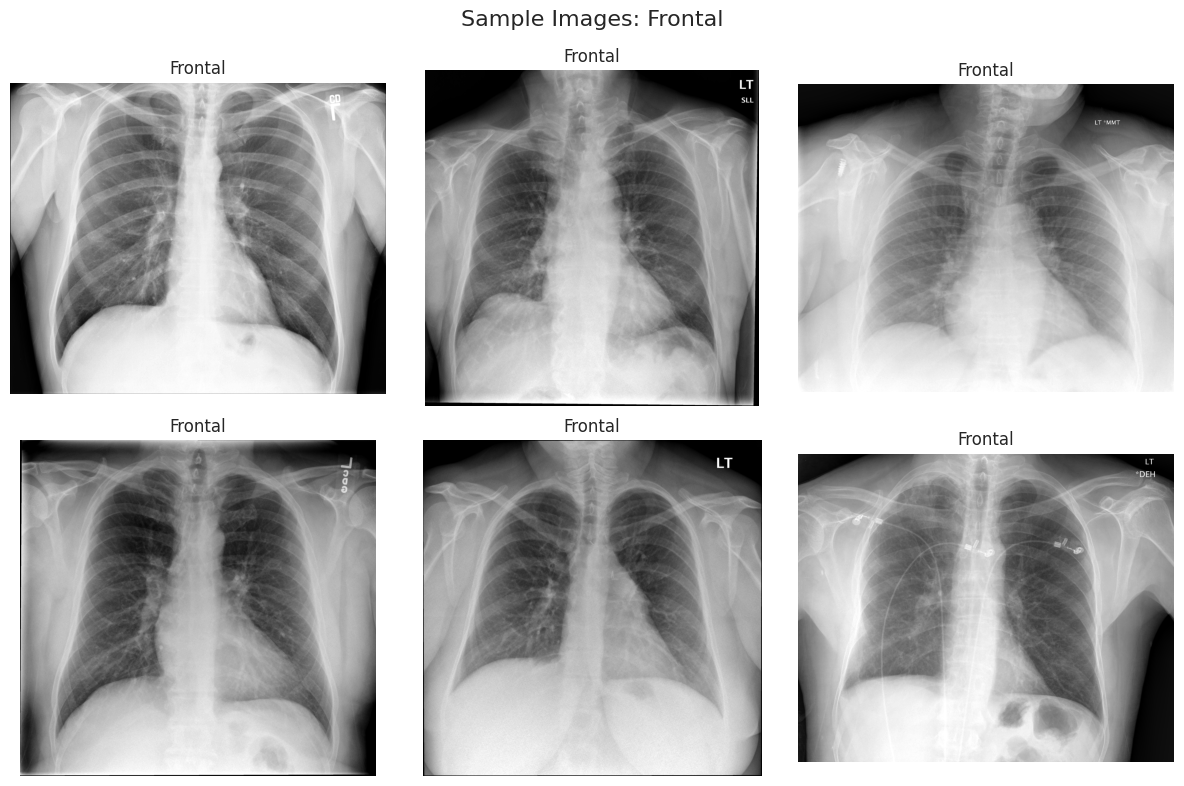

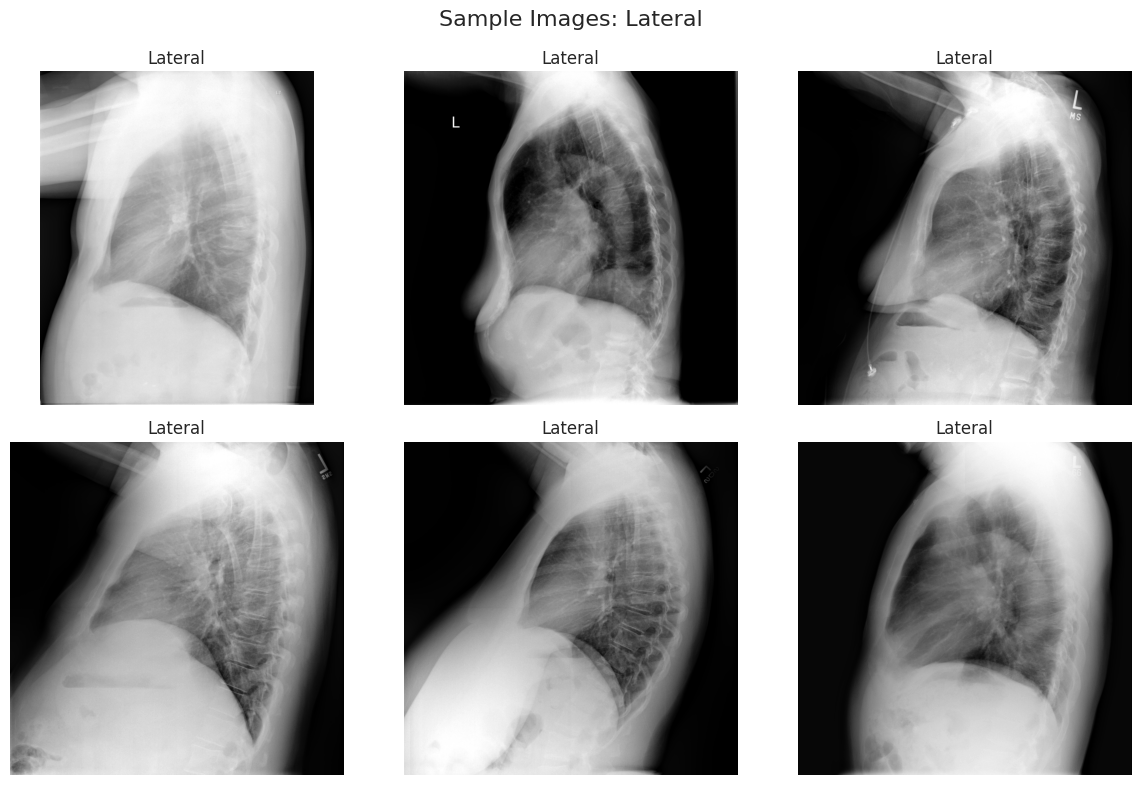

In [7]:
#  Sample Image Grid per Projection

def plot_samples_by_projection(proj, n=6, seed=42):
    subset = balanced_meta[balanced_meta.projection == proj]
    paths  = subset.sample(n, random_state=seed)['filepath'].tolist()
    
    cols  = 3
    rows  = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
    axes = axes.flatten()
    
    for ax, p in zip(axes, paths):
        img = Image.open(p)
        ax.imshow(img, cmap="gray")
        ax.set_title(proj)
        ax.axis("off")
    # hide any extra axes
    for ax in axes[len(paths):]:
        ax.axis("off")
        
    plt.suptitle(f"Sample Images: {proj}", fontsize=16)
    plt.tight_layout()
    plt.show()

for proj in balanced_meta['projection'].unique():
    plot_samples_by_projection(proj, n=6)

In [8]:
# Cell 6: Image Size Distribution (Height, Width)

# PIL .size returns (width, height), so reverse
dims = balanced_meta['filepath'].apply(lambda p: Image.open(p).size[::-1])
dims_df = pd.DataFrame(dims.tolist(), columns=['height','width'])

# Summary statistics
dims_df.describe()

,height,width
count,4771.000000,4771.000000
mean,2214.384406,2156.189268
std,216.181866,188.702505
min,1798.000000,1741.000000
25%,2048.000000,2048.000000
50%,2048.000000,2048.000000
75%,2496.000000,2172.500000
max,3001.000000,2891.000000


In [9]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a word to the vocabulary if it doesn't exist."""
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        """Return the index of the word. Return <unk> index if word not found."""
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        """Return the size of the vocabulary."""
        return len(self.word2idx)
import nltk
from collections import Counter

def build_vocab_from_dataframe(df, text_column, threshold):
    """Build a simple vocabulary wrapper from a DataFrame column (e.g., 'findings')."""
    counter = Counter()

    for i, text in enumerate(df[text_column]):
        if not isinstance(text, str):
            continue
        tokens = nltk.tokenize.word_tokenize(text.lower())
        counter.update(tokens)

        if (i + 1) % 1000 == 0:
            print(f"[{i+1}/{len(df)}] Tokenized the reports.")

    # Filter words by frequency threshold
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create the vocabulary and add special tokens
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add frequent words
    for word in words:
        vocab.add_word(word)

    print(f"Vocabulary size (threshold={threshold}): {len(vocab)}")
    return vocab

In [10]:
# Assuming your DataFrame is named `mbalanced_meta` and text column is 'findings'
vocab = build_vocab_from_dataframe(balanced_meta, text_column='findings', threshold=5)

[1000/4771] Tokenized the reports.
[2000/4771] Tokenized the reports.
[3000/4771] Tokenized the reports.
[4000/4771] Tokenized the reports.
Vocabulary size (threshold=5): 894


In [11]:
# Save to file
import pickle
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Load later
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [12]:
import argparse
import os
from PIL import Image

def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.Resampling.LANCZOS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        image_path = os.path.join(image_dir, image)
        with Image.open(image_path) as img:
            img = resize_image(img, size)
            img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0 or i+1 == num_images:
            print("[{}/{}] Resized the images and saved into '{}'."
                  .format(i+1, num_images, output_dir))


def main(args):
    image_dir = args.image_dir
    output_dir = args.output_dir
    image_size = [args.image_size, args.image_size]
    resize_images(image_dir, output_dir, image_size)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--image_dir', type=str, default='/kaggle/input/chest-xrays-indiana-university/images/images_normalized',
                        help='Directory for input images')
    parser.add_argument('--output_dir', type=str, default='/kaggle/working/resized/',
                        help='Directory to save resized images')
    parser.add_argument('--image_size', type=int, default=256,
                        help='Target size for resized images (square)')
    parser.add_argument('-f', type=str, help='Jupyter passes this automatically; ignore it', default=None)  # <- اضافه شده

    args = parser.parse_args()
    main(args)

[100/7470] Resized the images and saved into '/kaggle/working/resized/'.
[200/7470] Resized the images and saved into '/kaggle/working/resized/'.
[300/7470] Resized the images and saved into '/kaggle/working/resized/'.
[400/7470] Resized the images and saved into '/kaggle/working/resized/'.
[500/7470] Resized the images and saved into '/kaggle/working/resized/'.
[600/7470] Resized the images and saved into '/kaggle/working/resized/'.
[700/7470] Resized the images and saved into '/kaggle/working/resized/'.
[800/7470] Resized the images and saved into '/kaggle/working/resized/'.
[900/7470] Resized the images and saved into '/kaggle/working/resized/'.
[1000/7470] Resized the images and saved into '/kaggle/working/resized/'.
[1100/7470] Resized the images and saved into '/kaggle/working/resized/'.
[1200/7470] Resized the images and saved into '/kaggle/working/resized/'.
[1300/7470] Resized the images and saved into '/kaggle/working/resized/'.
[1400/7470] Resized the images and saved into '

In [13]:
import torch
import torch.utils.data as data
from PIL import Image
import os
import nltk
from torch.utils.data import Dataset

class ChestXrayDatasetFromDF(Dataset):
    def __init__(self, dataframe, image_dir, vocab, transform=None,
                 caption_column='findings', filename_column='filepath'):
        self.df = dataframe
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform
        self.caption_column = caption_column
        self.filename_column = filename_column

    def __getitem__(self, index):
        row = self.df.iloc[index]
        caption_text = str(row[self.caption_column]).lower()
        img_name = img_name = os.path.basename(str(row[self.filename_column]))

        image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        tokens = nltk.tokenize.word_tokenize(caption_text)
        caption = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]
        target = torch.Tensor(caption).long()

        return image, target

    def __len__(self):
        return len(self.df)


def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths


def get_loader_from_df(df, image_dir, vocab, transform, batch_size, shuffle, num_workers):
    dataset = ChestXrayDatasetFromDF(df, image_dir, vocab, transform)
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

In [35]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision.models import resnet152, ResNet152_Weights

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        weights = ResNet152_Weights.DEFAULT
        resnet = resnet152(weights=weights)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=50):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    
    def beam_search(self, features, vocab, beam_width=3):
        """Generate captions using beam search."""
        k = beam_width
        sequences = [[list(), 0.0, None]]  # [tokens, log_prob, states]
        inputs = features.unsqueeze(1)     # (1, 1, embed_size)
    
        for _ in range(self.max_seg_length):
            all_candidates = []
            for seq, score, states in sequences:
                if len(seq) > 0 and seq[-1] == vocab('<end>'):
                    # If already ended, keep sequence
                    all_candidates.append((seq, score, states))
                    continue
    
                hiddens, states = self.lstm(inputs, states)  # (1, 1, hidden_size)
                outputs = self.linear(hiddens.squeeze(1))    # (1, vocab_size)
                log_probs = torch.log_softmax(outputs, dim=1)  # Use log-probability for numerical stability
    
                # Get top-k predictions
                topk_log_probs, topk_indices = torch.topk(log_probs, k)
    
                for i in range(k):
                    word_id = topk_indices[0][i].item()
                    candidate = (seq + [word_id], score + topk_log_probs[0][i].item(), states)
                    all_candidates.append(candidate)
    
                # Next input (use top-1 for each candidate)
            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:k]
    
            # Update input for next iteration using best current candidate
            best_seq = sequences[0][0]
            next_input = torch.tensor([best_seq[-1]]).to(features.device)
            inputs = self.embed(next_input).unsqueeze(1)
    
            # Early stopping: if all sequences ended
            if all(seq[-1] == vocab('<end>') for seq, _, _ in sequences):
                break
    
        # Return the best sequence (ignoring <start> and stopping at <end>)
        final_seq = sequences[0][0]
        caption = []
        for word_id in final_seq:
            word = vocab.idx2word[word_id]
            if word == '<end>':
                break
            if word not in ['<start>', '<pad>']:
                caption.append(word)
        return caption

In [41]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
import pandas as pd
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')
from sklearn.model_selection import train_test_split

# from data_loader_df import get_loader_from_df 
# from model import EncoderCNN, DecoderRNN  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_bleu_scores(references, hypotheses):
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu1, bleu2, bleu3, bleu4

def evaluate_with_bleu(encoder, decoder, data_loader, criterion, vocab):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_samples = 0

    references = []
    hypotheses = []

    with torch.no_grad():
        for images, captions, lengths in data_loader:
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

            # Generate captions (sampled)
            sampled_ids_batch = decoder.sample(features)  # (batch_size, max_seq_length)
            sampled_ids_batch = sampled_ids_batch.cpu().numpy()

            for i in range(len(sampled_ids_batch)):
                sampled_ids = sampled_ids_batch[i]

                # Decode sampled caption
                sampled_caption = []
                for word_id in sampled_ids:
                    word = vocab.idx2word[word_id]
                    if word == '<end>':
                        break
                    if word not in ['<start>', '<pad>']:
                        sampled_caption.append(word)
                hypotheses.append(sampled_caption)

                # Decode ground truth caption
                real_caption = []
                for idx in captions[i].cpu().numpy():
                    word = vocab.idx2word[idx]
                    if word == '<end>':
                        break
                    if word not in ['<start>', '<pad>']:
                        real_caption.append(word)
                references.append([real_caption])  # Note: list of lists for corpus_bleu

    avg_loss = total_loss / total_samples
    encoder.train()
    decoder.train()

    bleu_scores = calculate_bleu_scores(references, hypotheses)
    return avg_loss, bleu_scores

def main(args):
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)

    # Transformations
    transform = transforms.Compose([
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Load vocabulary
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Load meta DataFrame
    meta = pd.read_csv(args.meta_path)

    # Split data
    train_df, temp_df = train_test_split(meta, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Load data loaders
    train_loader = get_loader_from_df(train_df, args.image_dir, vocab, transform,
                                      args.batch_size, shuffle=True, num_workers=args.num_workers)
    val_loader = get_loader_from_df(val_df, args.image_dir, vocab, transform,
                                    args.batch_size, shuffle=False, num_workers=args.num_workers)
    test_loader = get_loader_from_df(test_df, args.image_dir, vocab, transform,
                                     args.batch_size, shuffle=False, num_workers=args.num_workers)

    # Models
    encoder = EncoderCNN(args.embed_size).to(device)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)

    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=args.learning_rate)

    total_step = len(train_loader)
    for epoch in range(args.num_epochs):
        for i, (images, captions, lengths) in enumerate(train_loader):
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)

            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()

            if i % args.log_step == 0:
                print(f'Epoch [{epoch+1}/{args.num_epochs}], Step [{i}/{total_step}], '
                      f'Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}')

        # Validation at the end of epoch with BLEU
        val_loss, val_bleu_scores = evaluate_with_bleu(encoder, decoder, val_loader, criterion, vocab)
        print(f'>> Epoch [{epoch+1}] Validation Loss: {val_loss:.4f}, Perplexity: {np.exp(val_loss):5.4f}')
        print(f'>> Validation BLEU-1: {val_bleu_scores[0]:.4f}, BLEU-2: {val_bleu_scores[1]:.4f}, '
              f'BLEU-3: {val_bleu_scores[2]:.4f}, BLEU-4: {val_bleu_scores[3]:.4f}')

        # Save model
        torch.save(decoder.state_dict(), os.path.join(args.model_path, f'decoder-{epoch+1}.ckpt'))
        torch.save(encoder.state_dict(), os.path.join(args.model_path, f'encoder-{epoch+1}.ckpt'))

    # Final Test with BLEU
    test_loss, test_bleu_scores = evaluate_with_bleu(encoder, decoder, test_loader, criterion, vocab)
    print(f'>> Final Test Loss: {test_loss:.4f}, Perplexity: {np.exp(test_loss):5.4f}')
    print(f'>> Final Test BLEU-1: {test_bleu_scores[0]:.4f}, BLEU-2: {test_bleu_scores[1]:.4f}, '
          f'BLEU-3: {test_bleu_scores[2]:.4f}, BLEU-4: {test_bleu_scores[3]:.4f}')


# Arguments
class Args:
    # Paths
    model_path = 'models/'                                # Directory to save trained models
    crop_size = 224                                       # Image crop size (224 is standard for ResNet-152)
    vocab_path = '/kaggle/working/vocab.pkl'              # Path to vocabulary file
    meta_path = '/kaggle/working/balanced_meta.csv'       # Path to metadata
    image_dir = '/kaggle/working/resized'                 # Directory with resized images

    # Logging and saving
    log_step = 20                                          # Print log every N steps
    save_step = 2000                                       # Save model every N steps

    # Model hyperparameters
    embed_size = 256                                       # Dimensionality of embedding vectors
    hidden_size = 512                                      # Hidden size for LSTM
    num_layers = 1                                         # Number of LSTM layers

    # Training settings
    num_epochs = 25                                        # Number of training epochs
    batch_size = 64                                        # Batch size (balanced for Kaggle GPUs)
    num_workers = 4                                        # Number of workers for data loading
    learning_rate = 1e-3                                   # Initial learning rate

args = Args()
main(args)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch [1/25], Step [0/66], Loss: 6.7927, Perplexity: 891.3069
Epoch [1/25], Step [20/66], Loss: 4.0779, Perplexity: 59.0190
Epoch [1/25], Step [40/66], Loss: 3.3993, Perplexity: 29.9443
Epoch [1/25], Step [60/66], Loss: 2.7111, Perplexity: 15.0460
>> Epoch [1] Validation Loss: 2.7119, Perplexity: 15.0580
>> Validation BLEU-1: 0.2857, BLEU-2: 0.1877, BLEU-3: 0.1302, BLEU-4: 0.0924
Epoch [2/25], Step [0/66], Loss: 2.5981, Perplexity: 13.4382
Epoch [2/25], Step [20/66], Loss: 2.3959, Perplexity: 10.9779
Epoch [2/25], Step [40/66], Loss: 2.2367, Perplexity: 9.3619
Epoch [2/25], Step [60/66], Loss: 2.3582, Perplexity: 10.5722
>> Epoch [2] Validation Loss: 2.1726, Perplexity: 8.7808
>> Validation BLEU-1: 0.4139, BLEU-2: 0.2530, BLEU-3: 0.1790, BLEU-4: 0.1293
Epoch [3/25], Step [0/66], Loss: 2.1559, Perplexity: 8.6354
Epoch [3/25], Step [20/66], Loss: 1.8827, Perplexity: 6.5711
Epoch [3/25], Step [40/66], Loss: 1.8025, Perplexity: 6.0650
Epoch [3/25], Step [60/66], Loss: 1.7320, Perplexity: 5

In [42]:
import torch

# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters (adjust these according to your setup)
embed_size = 256
hidden_size = 512
num_layers = 1
batch_size = 64
crop_size = 224
learning_rate = 0.001
num_epochs = 10
log_step = 10
max_seq_length = 50

# Assume vocab is already loaded and contains idx2word and special tokens
vocab_size = len(vocab)

# Initialize the encoder and decoder models and move them to the device
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, max_seq_length).to(device)

# Load the trained model weights from checkpoint files
encoder.load_state_dict(torch.load('/kaggle/working/models/encoder-1.ckpt', map_location=device))
decoder.load_state_dict(torch.load('/kaggle/working/models/decoder-1.ckpt', map_location=device))

# Set the models to evaluation mode for inference
encoder.eval()
decoder.eval()


DecoderRNN(
  (embed): Embedding(894, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=894, bias=True)
)

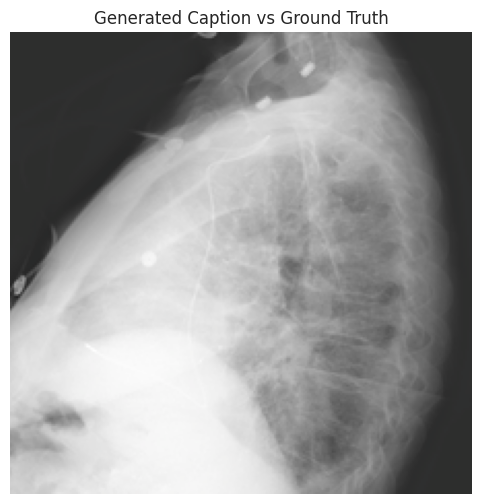

🔷 Ground Truth (findings):
there is a left-sided <unk> pacemaker . leads overlie the right ventricle and a lateral cardiac vein . the leads appear intact . the cardiac silhouette is mildly enlarged . there are mild diffuse bilateral interstitial opacities , xxxx pulmonary edema . there are xxxx opacities overlying the left lung base on the frontal view . no large pleural effusion is seen on the lateral view . no pneumothorax is identified .

🟢 Generated Caption (Sampled):
the heart is normal . the lungs are clear . no focal airspace disease . no pleural effusion or pneumothorax .

📊 ROUGE scores:
rouge1: precision=0.5882, recall=0.1562, fmeasure=0.2469
rouge2: precision=0.0625, recall=0.0159, fmeasure=0.0253
rougeL: precision=0.4706, recall=0.1250, fmeasure=0.1975


In [48]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch
import numpy as np
from rouge_score import rouge_scorer

# Get one batch from test_loader
train_df, temp_df = train_test_split(meta, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Transformations
transform = transforms.Compose([
    transforms.RandomCrop(args.crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

test_loader = get_loader_from_df(test_df, args.image_dir, vocab, transform,
                                 args.batch_size, shuffle=False, num_workers=args.num_workers)

data_iter = iter(test_loader)
images, captions, lengths = next(data_iter)

# Take the first image and caption from the batch
image_tensor = images[0].unsqueeze(0).to(device)  # add batch dimension
caption_tensor = captions[0]

# Decode ground truth caption
true_caption_words = []
for idx in caption_tensor.cpu().numpy():
    word = vocab.idx2word[idx]
    if word == '<end>':
        break
    if word not in ['<start>', '<pad>']:
        true_caption_words.append(word)
true_caption = ' '.join(true_caption_words)

with torch.no_grad():
    features = encoder(image_tensor)
    sampled_ids = decoder.sample(features)  # (1, max_seq_length)
    sampled_ids = sampled_ids[0].cpu().numpy()

# Decode generated caption
generated_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    if word == '<end>':
        break
    if word not in ['<start>', '<pad>']:
        generated_caption.append(word)
generated_caption_text = ' '.join(generated_caption)

# Convert normalized tensor to image for display
# Undo normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
image_show = inv_normalize(images[0]).clamp(0,1)  # clamp to valid range
image_np = image_show.permute(1, 2, 0).cpu().numpy()

plt.imshow(image_np)
plt.axis('off')
plt.title("Generated Caption vs Ground Truth")
plt.show()

print(f"🔷 Ground Truth (findings):\n{true_caption}\n")
print(f"🟢 Generated Caption (Sampled):\n{generated_caption_text}\n")

# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(true_caption, generated_caption_text)

print("📊 ROUGE scores:")
for key in scores:
    print(f"{key}: precision={scores[key].precision:.4f}, recall={scores[key].recall:.4f}, fmeasure={scores[key].fmeasure:.4f}")

